# GPU info

In [1]:
!nvidia-smi

Fri May 16 13:08:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Install

In [2]:
!pip uninstall -y torchmetrics

Found existing installation: torchmetrics 1.2.0
Uninstalling torchmetrics-1.2.0:
  Successfully uninstalled torchmetrics-1.2.0


In [3]:
!pip3 install -q segmentation_models_pytorch torchmetrics==1.2 imageio tqdm

# Import

In [4]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR

import torchvision
import torchvision.transforms.v2 as T
from torchvision.datasets import VisionDataset
from torchvision import tv_tensors

import segmentation_models_pytorch as smp
from torchmetrics import Dice, MeanMetric

from PIL import Image, ImageChops
from imageio import mimsave

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm
from glob import glob
from os import path, listdir, getcwd, makedirs
from typing import Optional, Callable

In [5]:
torch.__version__, torchvision.__version__

('2.6.0+cu124', '0.21.0+cu124')

# Device

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Download dataset

In [7]:
!curl -L -o "/content/lgg-mri-segmentation.zip" "https://www.kaggle.com/api/v1/datasets/download/mateuszbuda/lgg-mri-segmentation"
!unzip -q "/content/lgg-mri-segmentation.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  713M  100  713M    0     0   214M      0  0:00:03  0:00:03 --:--:--  234M
replace kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Arguments

In [8]:
loss_alpha = 0.5
batch_size = 64
epochs = 20
backbone = "mobilenet_v2"
final_model_name = "final_model.pt"

dataset_root = path.join(getcwd(), "kaggle_3m")
# dataset_root = path.join(getcwd(), "kaggle_3m_cleaned")

# Helpers

In [9]:
def num_parameters(model):
    params = sum([p.numel() for p in model.parameters() if p.requires_grad_])
    print(f"The number of trainable parameters: {params:,}")

In [10]:
def create_df_phase(phase_file="train.txt"):
    phase_file = phase_file.lower()

    assert phase_file in ["train.txt", "eval.txt", "test.txt"], "Phase_file must be one of [train.txt, eval.txt, test.txt]"

    with open(path.join(getcwd(), phase_file), 'r') as f:
        train_ids = f.read()
        f.close()
        train_ids = train_ids.split(', ')

        selected_columns = ["patient_id", "slice", "slice_path"]

        df_train = df_images[df_images.patient_id.isin(train_ids)][selected_columns].copy()
        df_train = df_train.merge(df_masks[df_masks.patient_id.isin(train_ids)][selected_columns], on=["patient_id", "slice"])

        df_train.rename(columns={"slice_path_x": "img_path", "slice_path_y": "msk_path"}, inplace=True)

        df_train.to_csv(path.join(getcwd(), phase_file.replace("txt", "csv")), index=False)

In [11]:
def train_one_epoch(dataloader, model, optimizer_fn, loss_fn, metric_fn, avg_fn, ep, device):
    model.train()

    metric_fn.reset()
    avg_fn.reset()

    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

            # Calculate losses and metrics
            avg_fn.update(loss, weight=len(y_batch))
            avg_loss = avg_fn.compute().item()

            metric_fn.update(yp, y_batch)
            avg_metric = metric_fn.compute().item()

            trange.set_postfix(loss=avg_loss, metric=avg_metric)

    return model, avg_loss, avg_metric

In [12]:
def eval_one_epoch(dataloader, model, loss_fn, metric_fn, avg_fn, device):
    model.eval()

    metric_fn.reset()
    avg_fn.reset()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Calculate losses and metrics
            avg_fn.update(loss, weight=len(y_batch))
            avg_loss = avg_fn.compute().item()

            metric_fn.update(yp, y_batch)
            avg_metric = metric_fn.compute().item()

        print(f"Eval ==> loss: {avg_loss:.4}\tmetric: {avg_metric:.4}\n")

    return avg_loss, avg_metric

In [13]:
def combined_loss_fn(preds, target, alpha=loss_alpha):
    dice_loss = smp.losses.DiceLoss(mode="binary", ignore_index=0)
    bce_loss = nn.BCEWithLogitsLoss()

    return alpha * dice_loss(preds, target) + (1 - alpha) * bce_loss(preds, target.to(torch.float32))

# Data

## Primary overview to the dataset

In [14]:
paths = glob(path.join(dataset_root, "**"), recursive=True)
paths = list(filter(lambda x: x.endswith(".tif"), paths))

len(paths)

7858

In [15]:
paths[:5]

['/content/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_25.tif',
 '/content/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_19_mask.tif',
 '/content/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_66.tif',
 '/content/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_16.tif',
 '/content/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_60_mask.tif']

In [16]:
paths[0].split(path.sep)[-1].split('_')

['TCGA', 'FG', 'A60K', '20040224', '25.tif']

In [17]:
paths[1].split(path.sep)[-1].split('_')

['TCGA', 'FG', 'A60K', '20040224', '19', 'mask.tif']

In [18]:
df = pd.read_csv(path.join(dataset_root, "data.csv"))

In [19]:
df.describe()

,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
count,92.000000,109.000000,110.000000,108.000000,98.000000,105.000000,110.000000,109.000000,109.000000,109.0,109.000000,109.000000,109.000000,109.000000,108.000000,102.000000,109.000000
mean,2.445652,3.678899,1.900000,1.722222,2.367347,1.895238,1.763636,2.128440,1.532110,1.0,2.009174,3.513761,1.486239,45.834862,2.907407,1.970588,0.247706
std,1.180092,1.169684,0.789263,0.862872,1.125045,0.663960,0.855927,0.850935,0.501273,0.0,0.995317,1.863960,0.502119,13.797151,0.291212,0.169792,0.433674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,20.000000,2.000000,1.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.000000,1.000000,34.000000,3.000000,2.000000,0.000000
50%,2.000000,4.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.0,2.000000,2.000000,1.000000,47.000000,3.000000,2.000000,0.000000
75%,4.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,58.000000,3.000000,2.000000,0.000000
max,4.000000,5.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,2.000000,1.0,3.000000,6.000000,2.000000,75.000000,3.000000,2.000000,1.000000


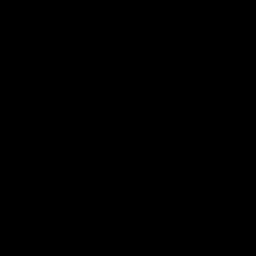

In [20]:
img = Image.open(paths[30])
img

In [21]:
img_t = T.functional.to_image(img)
*img_t.shape, str(img_t.dtype).replace("torch.", ''), img_t.min(), img_t.max().item()

(1, 256, 256, 'uint8', tensor(0, dtype=torch.uint8), 0)

## Data prepration

### Read data.csv

In [22]:
df_data = pd.read_csv(path.join(dataset_root, "data.csv"))

### Seperate images from their relevant masks

In [23]:
images_full_path = list(filter(lambda x: not x.endswith("_mask.tif"), paths))
masks_full_path = list(filter(lambda x: x.endswith("_mask.tif"), paths))

len(images_full_path), len(masks_full_path), images_full_path[0]

(3929,
 3929,
 '/content/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_25.tif')

### Make columns (patient_id, slice, slice_path, size, dtype, max_pixel)

In [24]:
images_info, masks_info = [], []

for img_path, msk_path in zip(images_full_path, masks_full_path):

    # Image
    img = Image.open(img_path)
    img = T.functional.to_image(img)
    patient_id, slice_date, slice_num = img_path.split(path.sep)[-1].replace(".tif", '').split('_')[-3:]
    img_info = [patient_id, int(slice_num), slice_date, img_path, *img.shape, str(img.dtype).replace("torch.", ''), img.max().item()]
    images_info.append(img_info)

    # Mask
    msk = Image.open(msk_path)
    msk = T.functional.to_image(msk)
    patient_id, slice_date, slice_num = msk_path.split(path.sep)[-1].split('_')[-4:-1]
    msk_info = [patient_id, int(slice_num), slice_date, msk_path, *msk.shape, str(img.dtype).replace("torch.", ''), msk.max().item()]
    masks_info.append(msk_info)

### Create dataframe for images and their relevant masks

In [25]:
columns_name = ["patient_id", "slice", "slice_date", "slice_path", "channel", "width", "height", "sample_dtype", "max_pixel"]

df_images = pd.DataFrame(images_info, columns=columns_name).sort_values(["patient_id", "slice"])
df_masks = pd.DataFrame(masks_info, columns=columns_name).sort_values(["patient_id", "slice"])

df_images

,patient_id,slice,slice_date,slice_path,channel,width,height,sample_dtype,max_pixel
1588,4941,1,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,215
1604,4941,2,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,219
1602,4941,3,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,240
1607,4941,4,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,255
1594,4941,5,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,255
...,...,...,...,...,...,...,...,...,...
2219,A61B,84,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,8
2202,A61B,85,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,8
2254,A61B,86,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,9
2263,A61B,87,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,8


## Create a GIF from a patient's scans

In [26]:
patient_id = "7881"

visual_img = df_images[df_images.patient_id == patient_id]
visual_msk = df_masks[df_masks.patient_id == patient_id]

imgs = []

for i, (img, msk) in enumerate(zip(visual_img.values, visual_msk.values)):
    img = Image.open(img[3])
    msk = Image.open(msk[3])

    res = ImageChops.add(img, msk.convert("RGB"))
    imgs.append(res)

makedirs(path.join(getcwd(), "images", "gifs"), exist_ok=True)
mimsave(path.join(getcwd(), "images", "gifs", f"{patient_id}.gif"), imgs, duration=100, loop=0)

## EDA

### data.csv dataframe (Additional information of all patients)

#### Gender

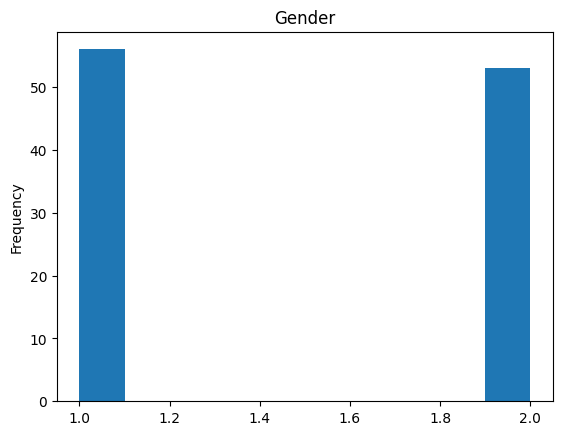

In [27]:
df_data.gender.plot(kind="hist", title="Gender");

#### Age at initial pathologic

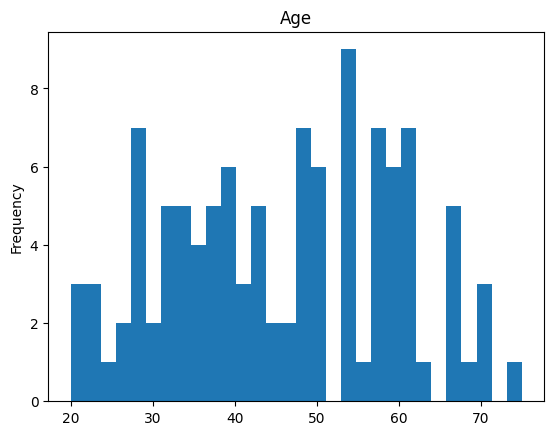

In [28]:
df_data.age_at_initial_pathologic.plot(kind="hist", title="Age", bins=30);

#### Race

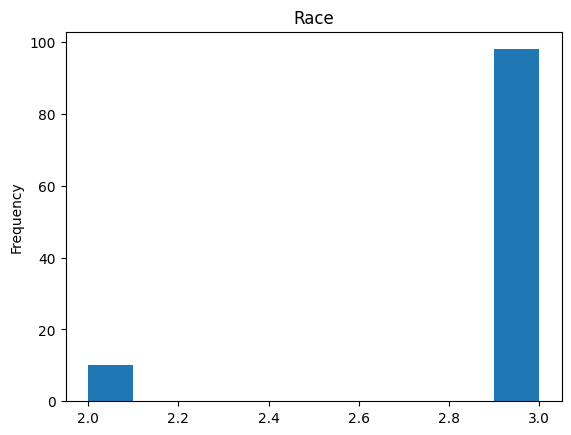

In [29]:
df_data.race.plot(kind="hist", title="Race");

#### Ethnicity

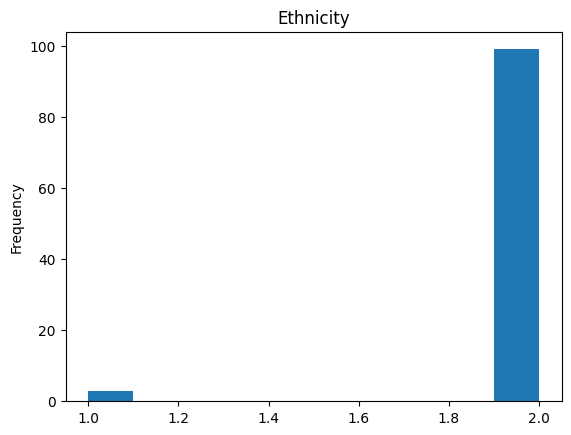

In [30]:
df_data.ethnicity.plot(kind="hist", title="Ethnicity");

#### Death Status

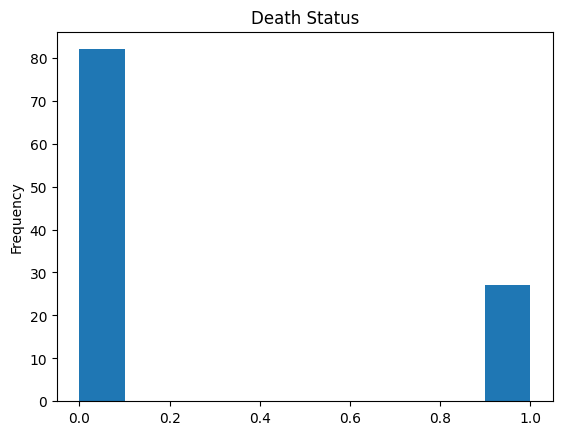

In [31]:
df_data.death01.plot(kind="hist", title="Death Status");

### Images dataframe

In [32]:
df_images

,patient_id,slice,slice_date,slice_path,channel,width,height,sample_dtype,max_pixel
1588,4941,1,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,215
1604,4941,2,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,219
1602,4941,3,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,240
1607,4941,4,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,255
1594,4941,5,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,3,256,256,uint8,255
...,...,...,...,...,...,...,...,...,...
2219,A61B,84,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,8
2202,A61B,85,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,8
2254,A61B,86,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,9
2263,A61B,87,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,3,256,256,uint8,8


### Masks dataframe

In [33]:
df_masks

,patient_id,slice,slice_date,slice_path,channel,width,height,sample_dtype,max_pixel
1608,4941,1,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1,256,256,uint8,0
1597,4941,2,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1,256,256,uint8,0
1602,4941,3,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1,256,256,uint8,0
1610,4941,4,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1,256,256,uint8,0
1605,4941,5,19960909,/content/kaggle_3m/TCGA_CS_4941_19960909/TCGA_...,1,256,256,uint8,0
...,...,...,...,...,...,...,...,...,...
2263,A61B,84,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,1,256,256,uint8,0
2249,A61B,85,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,1,256,256,uint8,0
2251,A61B,86,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,1,256,256,uint8,0
2182,A61B,87,19991127,/content/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_...,1,256,256,uint8,0


### Sizes and dtype

In [34]:
df_images.channel.unique(), df_images.width.unique(), df_images.height.unique(), df_images.sample_dtype.unique()

(array([3]), array([256]), array([256]), array(['uint8'], dtype=object))

In [35]:
df_masks.channel.unique(), df_masks.width.unique(), df_masks.height.unique(), df_masks.sample_dtype.unique()

(array([1]), array([256]), array([256]), array(['uint8'], dtype=object))

### The number of pixels

In [36]:
df_images.max_pixel.min()

3

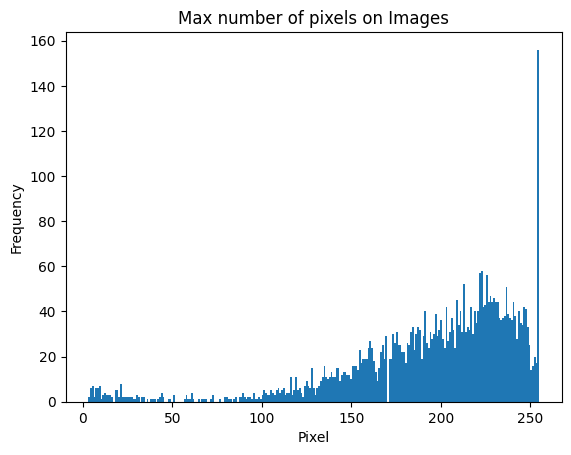

In [37]:
df_images.max_pixel.plot(kind="hist", title="Max number of pixels on Images", xlabel="Pixel", bins=255);

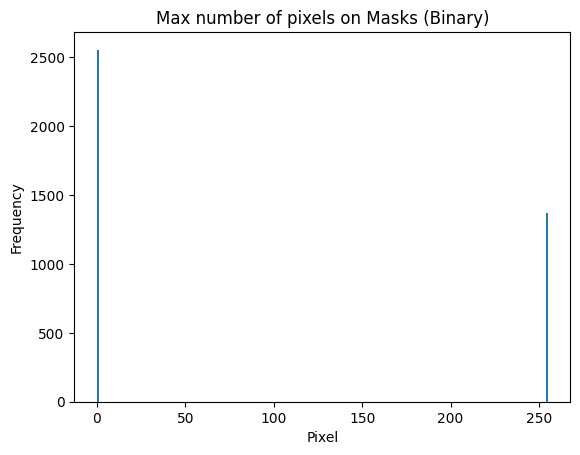

In [38]:
df_masks.max_pixel.plot(kind="hist", title="Max number of pixels on Masks (Binary)", xlabel="Pixel", bins=255);

### Visualize each channel separately

/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11.tif
/content/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11_mask.tif 



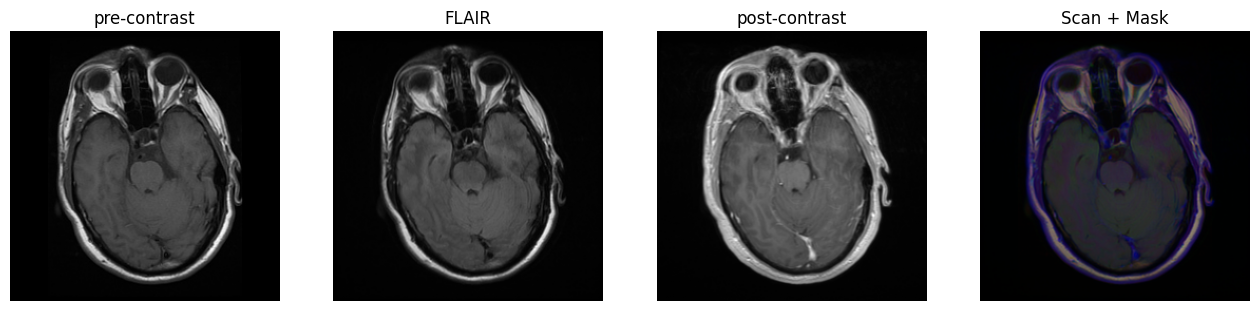

In [39]:
sample_idx = torch.randint(0, df_images.shape[0], (1,)).item()

img = Image.open(df_images.iloc[sample_idx].slice_path)
msk = Image.open(df_masks.iloc[sample_idx].slice_path)

print(df_images.iloc[sample_idx].slice_path)
print(df_masks.iloc[sample_idx].slice_path, "\n")

img = T.functional.to_image(img)
msk = T.functional.to_image(msk)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 7))

titles = ["pre-contrast", "FLAIR", "post-contrast", "Scan + Mask"]

axs[0].imshow(img[0], cmap="gray")
axs[1].imshow(img[1], cmap="gray")
axs[2].imshow(img[2], cmap="gray")

axs[3].imshow(img.permute(1, 2, 0), cmap="gray")
axs[3].imshow(msk.permute(1, 2, 0), cmap="gray", alpha=0.4)

for i, ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.axis("off");

## Split data to Train, Eval, and Test

In [40]:
train_set, eval_set, test_set = random_split(df_images.patient_id.unique(), lengths=[0.8, 0.1, 0.1])

with open(path.join(getcwd(), "train.txt"), 'w') as f:
    f.write(str(list(train_set)).replace('[', '').replace(']', '').replace('\'', '').replace("\n", ''))
    f.close()

with open(path.join(getcwd(), "eval.txt"), 'w') as f:
    f.write(str(list(eval_set)).replace('[', '').replace(']', '').replace('\'', '').replace("\n", ''))
    f.close()

with open(path.join(getcwd(), "test.txt"), 'w') as f:
    f.write(str(list(test_set)).replace('[', '').replace(']', '').replace('\'', '').replace("\n", ''))
    f.close()

len(train_set), len(eval_set), len(test_set)

(88, 11, 11)

## Create df_train, df_eval, and df_test

### Train dataframe

In [41]:
create_df_phase("train.txt")

### Eval dataframe

In [42]:
create_df_phase("eval.txt")

### Test dataframe

In [43]:
create_df_phase("test.txt")

## Implement custom dataset

In [44]:
class BrainMRIDataset(VisionDataset):
    def __init__(self, csv_file: str, transforms: Optional[Callable] = None, memory: Optional[bool] = False):
        super(BrainMRIDataset, self).__init__(transforms=transforms)

        self.df = pd.read_csv(csv_file)
        self.memory = memory

        self.img_ls = []
        self.msk_ls = []

        if memory:
            self._save_memory()

    def __getitem__(self, item_idx):

        if self.memory:
            img = self.img_ls[item_idx]
            msk = self.msk_ls[item_idx]
        else:
            patient_id, slice_, img_path, msk_path = self.df.iloc[item_idx]

            img = self._read_sample(img_path)
            msk = self._read_sample(msk_path, is_img=False)

        if self.transforms is not None:
            img, msk = self.transforms(img, msk)

        return img, msk.int()

    def _save_memory(self):
        for patient_id, slice_, img_path, msk_path in self.df.values:
            img = self._read_sample(img_path)
            self.img_ls.append(img)

            msk = self._read_sample(msk_path, is_img=False)
            self.msk_ls.append(msk)

    def _read_sample(self, path_, is_img=True):
        samp = Image.open(path_)
        samp = T.functional.to_image(samp)

        if is_img:
            samp = self._normalizer(samp)
            samp = tv_tensors.Image(samp)
        else:
            # samp = samp.repeat(3, 1, 1)
            samp = samp.float() / 255.0
            samp = tv_tensors.Mask(samp)

        return samp

    def _normalizer(self, x):
        return (x - x.min()) / (x.max() - x.min())

    def __len__(self):
        return self.df.shape[0]

## Transforms

In [45]:
train_trainsforms = T.Compose([
    T.Resize((256, 256)),
    T.RandomPhotometricDistort(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(35),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

eval_trainsforms = T.Compose([
    T.Resize((256, 256)),
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

In [46]:
d = BrainMRIDataset("./train.csv", train_trainsforms, False)

In [47]:
rand_idx = torch.randint(0, len(d), (45,))

fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(18, 25))
axs = axs.flatten()

for i, idx in enumerate(rand_idx):
    img_, msk_ = d[idx.item()]

    axs[i].imshow(img_.permute(1, 2, 0), cmap="gray")
    axs[i].imshow(msk_.permute(1, 2, 0), alpha=0.4, cmap="gray")

for ax in axs:
    ax.axis("off")

Output hidden; open in https://colab.research.google.com to view.

## Create datasets

In [48]:
train_set = BrainMRIDataset(path.join(getcwd(), "train.csv"), train_trainsforms, True)
eval_set = BrainMRIDataset(path.join(getcwd(), "eval.csv"), eval_trainsforms, True)
test_set = BrainMRIDataset(path.join(getcwd(), "test.csv"), eval_trainsforms, False)

len(train_set), len(eval_set), len(test_set)

(3179, 439, 311)

## Dataloaders

In [49]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_set, batch_size=batch_size*2)
test_loader = DataLoader(test_set, batch_size=batch_size*2)

In [50]:
img, msk = next(iter(train_loader))
img.shape, msk.shape, msk.min(), msk.max(), msk.dtype, msk.unique()

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 1, 256, 256]),
 tensor(0, dtype=torch.int32),
 tensor(1, dtype=torch.int32),
 torch.int32,
 tensor([0, 1], dtype=torch.int32))

# Model

In [52]:
model = smp.Unet(encoder_name=backbone, encoder_weights="imagenet", classes=1, in_channels=3)
num_parameters(model)

The number of trainable parameters: 6,628,945


# Train phase

## Check paths

### Forward

In [ ]:
img, msk = next(iter(train_loader))

with torch.inference_mode():
    yp = model(img)
    loss = combined_loss_fn(yp, msk)

torch.cuda.empty_cache()

loss.item()

torch.Size([16, 3, 256, 256]) tensor(0.) tensor(1.)
torch.Size([16, 1, 256, 256]) tensor(0, dtype=torch.int32) tensor(1, dtype=torch.int32)
torch.Size([16, 1, 256, 256]) tensor(-5.1086) tensor(15.6625)


0.4246821999549866

### Backward

In [ ]:
model = smp.Unet(encoder_name=backbone, encoder_weights="imagenet", classes=1, in_channels=3).to(device)
num_parameters(model)

The number of trainable parameters: 8,757,105


In [ ]:
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
metric_fn = Dice(ignore_index=0).to(device)
avg_fn = MeanMetric().to(device)

In [ ]:
_, mini_train_set = random_split(train_set, lengths=[0.8, 0.2])
_, mini_eval_set = random_split(eval_set, lengths=[0.8, 0.2])

mini_train_loader = DataLoader(mini_train_set, batch_size=batch_size, shuffle=True)
mini_eval_loader = DataLoader(mini_eval_set, batch_size=batch_size)

len(mini_train_set), len(mini_eval_set)

(632, 63)

In [ ]:
for ep in range(5):
    model, _, _ = train_one_epoch(mini_train_loader, model, optimizer, combined_loss_fn, metric_fn, avg_fn, ep, device)
    eval_one_epoch(mini_eval_loader, model, combined_loss_fn, metric_fn, avg_fn, device)

torch.cuda.empty_cache()

Epoch 0: 100%|███████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.25s/ batch, loss=0.369, metric=0.0523]


Eval ==> loss: 0.3069	metric: 0.08249



Epoch 1: 100%|████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.25s/ batch, loss=0.231, metric=0.102]


Eval ==> loss: 0.2545	metric: 0.1099



Epoch 2: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/ batch, loss=0.18, metric=0.201]


Eval ==> loss: 0.2103	metric: 0.2197



Epoch 3: 100%|████████████████████████████████████████████████████████████| 40/40 [00:49<00:00,  1.25s/ batch, loss=0.147, metric=0.307]


Eval ==> loss: 0.1839	metric: 0.311



Epoch 4: 100%|████████████████████████████████████████████████████████████| 40/40 [00:50<00:00,  1.26s/ batch, loss=0.123, metric=0.406]


Eval ==> loss: 0.1559	metric: 0.413



## Find efficient hyper-parameters

In [ ]:
metric_fn = Dice(ignore_index=0).to(device)
avg_fn = MeanMetric().to(device)

In [ ]:
for lr in [0.00001, 0.0001, 0.0005, 0.001]:
    for wd in [0, 1e-5, 1e-4]:
        print(f"\nLR: {lr}, WD: {wd}")

        model = smp.Unet(encoder_name=backbone, encoder_weights="imagenet", classes=1, in_channels=3).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)

        for ep in range(3):
            model, _, _ = train_one_epoch(train_loader, model, optimizer, combined_loss_fn, metric_fn, avg_fn, ep, device)
            eval_one_epoch(eval_loader, model, combined_loss_fn, metric_fn, avg_fn, device)

        torch.cuda.empty_cache()


LR: 1e-05, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.26s/ batch, loss=0.388, metric=0.0528]


Eval ==> loss: 0.3025	metric: 0.2451



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.291, metric=0.0735]


Eval ==> loss: 0.2168	metric: 0.1754



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.225, metric=0.102]


Eval ==> loss: 0.1911	metric: 0.2224


LR: 1e-05, WD: 1e-05


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.27s/ batch, loss=0.453, metric=0.033]


Eval ==> loss: 0.4154	metric: 0.08024



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.27s/ batch, loss=0.317, metric=0.0723]


Eval ==> loss: 0.2721	metric: 0.1358



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.247, metric=0.122]


Eval ==> loss: 0.2445	metric: 0.1736


LR: 1e-05, WD: 0.0001


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.26s/ batch, loss=0.396, metric=0.0455]


Eval ==> loss: 0.3832	metric: 0.07301



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.26s/ batch, loss=0.319, metric=0.074]


Eval ==> loss: 0.3056	metric: 0.1195



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:15<00:00,  1.27s/ batch, loss=0.232, metric=0.104]


Eval ==> loss: 0.183	metric: 0.1767


LR: 0.0001, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.301, metric=0.0624]


Eval ==> loss: 0.1984	metric: 0.6202



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.142, metric=0.456]


Eval ==> loss: 0.1056	metric: 0.6204



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0858, metric=0.51]


Eval ==> loss: 0.07369	metric: 0.6079


LR: 0.0001, WD: 1e-05


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.261, metric=0.0885]


Eval ==> loss: 0.1523	metric: 0.5654



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.122, metric=0.439]


Eval ==> loss: 0.09256	metric: 0.5897



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0715, metric=0.511]


Eval ==> loss: 0.06392	metric: 0.689


LR: 0.0001, WD: 0.0001


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.238, metric=0.101]


Eval ==> loss: 0.1612	metric: 0.5554



Epoch 1: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.108, metric=0.445]


Eval ==> loss: 0.08549	metric: 0.629



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0622, metric=0.538]


Eval ==> loss: 0.05347	metric: 0.6955


LR: 0.0005, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0984, metric=0.256]


Eval ==> loss: 0.04381	metric: 0.6223



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:12<00:00,  1.25s/ batch, loss=0.0358, metric=0.492]


Eval ==> loss: 0.03938	metric: 0.5473



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0254, metric=0.565]


Eval ==> loss: 0.03148	metric: 0.614


LR: 0.0005, WD: 1e-05


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.105, metric=0.251]


Eval ==> loss: 0.04537	metric: 0.6625



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0367, metric=0.479]


Eval ==> loss: 0.03673	metric: 0.6018



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0261, metric=0.566]


Eval ==> loss: 0.03301	metric: 0.5886


LR: 0.0005, WD: 0.0001


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:14<00:00,  1.26s/ batch, loss=0.108, metric=0.223]


Eval ==> loss: 0.05266	metric: 0.6147



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:12<00:00,  1.25s/ batch, loss=0.0346, metric=0.483]


Eval ==> loss: 0.03947	metric: 0.569



Epoch 2: 100%|██████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0303, metric=0.52]


Eval ==> loss: 0.03147	metric: 0.7124


LR: 0.001, WD: 0


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0772, metric=0.286]


Eval ==> loss: 0.04877	metric: 0.621



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0328, metric=0.476]


Eval ==> loss: 0.03499	metric: 0.6441



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0311, metric=0.478]


Eval ==> loss: 0.0335	metric: 0.7427


LR: 0.001, WD: 1e-05


Epoch 0: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0887, metric=0.266]


Eval ==> loss: 0.04355	metric: 0.5563



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.25s/ batch, loss=0.0392, metric=0.427]


Eval ==> loss: 0.03757	metric: 0.7337



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:13<00:00,  1.26s/ batch, loss=0.0259, metric=0.551]


Eval ==> loss: 0.02641	metric: 0.6909


LR: 0.001, WD: 0.0001


Epoch 0: 100%|██████████████████████████████████████████████████████████| 202/202 [04:12<00:00,  1.25s/ batch, loss=0.102, metric=0.266]


Eval ==> loss: 0.3253	metric: 0.5022



Epoch 1: 100%|█████████████████████████████████████████████████████████| 202/202 [04:11<00:00,  1.25s/ batch, loss=0.0402, metric=0.443]


Eval ==> loss: 0.07954	metric: 0.748



Epoch 2: 100%|█████████████████████████████████████████████████████████| 202/202 [04:11<00:00,  1.24s/ batch, loss=0.0346, metric=0.461]


Eval ==> loss: 0.05475	metric: 0.7394



## Full Train

In [53]:
model = smp.Unet(encoder_name=backbone, encoder_weights="imagenet", classes=1, in_channels=3).to(device)
num_parameters(model)

The number of trainable parameters: 6,628,945


In [55]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
schedular = MultiStepLR(optimizer, milestones=[4, 10], gamma=0.3)
metric_fn = Dice(ignore_index=0).to(device)
avg_fn = MeanMetric().to(device)

In [56]:
best_model = model
min_eval_loss = torch.inf

In [57]:
train_loss_hist, train_metric_hist = [], []
eval_loss_hist, eval_metric_hist = [], []

In [58]:
start_time = datetime.now().replace(microsecond=0)

for ep in range(epochs):
    model, train_loss, train_metric = train_one_epoch(train_loader, model, optimizer, combined_loss_fn, metric_fn, avg_fn, ep, device)
    eval_loss, eval_metric = eval_one_epoch(eval_loader, model, combined_loss_fn, metric_fn, avg_fn, device)

    if min_eval_loss > eval_loss:
        best_model = model
        min_eval_loss = eval_loss

    train_loss_hist.append(train_loss)
    eval_loss_hist.append(eval_loss)
    train_metric_hist.append(train_metric)
    eval_metric_hist.append(eval_metric)

    schedular.step()

end_time = datetime.now().replace(microsecond=0)

torch.cuda.empty_cache()

print(f"Comupation Time: {end_time - start_time}")

Epoch 0: 100%|██████████| 50/50 [01:29<00:00,  1.79s/ batch, loss=0.163, metric=0.318]


Eval ==> loss: 0.08451	metric: 0.3155



Epoch 1: 100%|██████████| 50/50 [01:29<00:00,  1.78s/ batch, loss=0.054, metric=0.554]


Eval ==> loss: 0.06248	metric: 0.3884



Epoch 2: 100%|██████████| 50/50 [01:31<00:00,  1.83s/ batch, loss=0.039, metric=0.609]


Eval ==> loss: 0.03756	metric: 0.5986



Epoch 3: 100%|██████████| 50/50 [01:29<00:00,  1.78s/ batch, loss=0.0336, metric=0.638]


Eval ==> loss: 0.05498	metric: 0.5863



Epoch 4: 100%|██████████| 50/50 [01:28<00:00,  1.77s/ batch, loss=0.0269, metric=0.688]


Eval ==> loss: 0.03922	metric: 0.7095



Epoch 5: 100%|██████████| 50/50 [01:28<00:00,  1.77s/ batch, loss=0.0241, metric=0.716]


Eval ==> loss: 0.0391	metric: 0.6827



Epoch 6: 100%|██████████| 50/50 [01:27<00:00,  1.76s/ batch, loss=0.0222, metric=0.732]


Eval ==> loss: 0.03501	metric: 0.7172



Epoch 7: 100%|██████████| 50/50 [01:28<00:00,  1.78s/ batch, loss=0.0213, metric=0.744]


Eval ==> loss: 0.04009	metric: 0.7307



Epoch 8: 100%|██████████| 50/50 [01:30<00:00,  1.81s/ batch, loss=0.0198, metric=0.748]


Eval ==> loss: 0.047	metric: 0.7435



Epoch 9: 100%|██████████| 50/50 [01:29<00:00,  1.78s/ batch, loss=0.0197, metric=0.751]


Eval ==> loss: 0.04091	metric: 0.7597



Epoch 10: 100%|██████████| 50/50 [01:28<00:00,  1.78s/ batch, loss=0.0186, metric=0.767]


Eval ==> loss: 0.0347	metric: 0.7404



Epoch 11: 100%|██████████| 50/50 [01:28<00:00,  1.76s/ batch, loss=0.0182, metric=0.767]


Eval ==> loss: 0.03504	metric: 0.7175



Epoch 12: 100%|██████████| 50/50 [01:28<00:00,  1.76s/ batch, loss=0.0175, metric=0.773]


Eval ==> loss: 0.03432	metric: 0.6875



Epoch 13: 100%|██████████| 50/50 [01:27<00:00,  1.76s/ batch, loss=0.0176, metric=0.771]


Eval ==> loss: 0.0302	metric: 0.7006



Epoch 14: 100%|██████████| 50/50 [01:27<00:00,  1.74s/ batch, loss=0.0169, metric=0.774]


Eval ==> loss: 0.03323	metric: 0.7109



Epoch 15: 100%|██████████| 50/50 [01:27<00:00,  1.75s/ batch, loss=0.017, metric=0.776]


Eval ==> loss: 0.03433	metric: 0.6883



Epoch 16: 100%|██████████| 50/50 [01:28<00:00,  1.77s/ batch, loss=0.0165, metric=0.784]


Eval ==> loss: 0.03722	metric: 0.7358



Epoch 17: 100%|██████████| 50/50 [01:28<00:00,  1.77s/ batch, loss=0.0164, metric=0.775]


Eval ==> loss: 0.03325	metric: 0.7005



Epoch 18: 100%|██████████| 50/50 [01:27<00:00,  1.75s/ batch, loss=0.0164, metric=0.781]


Eval ==> loss: 0.03432	metric: 0.7278



Epoch 19: 100%|██████████| 50/50 [01:27<00:00,  1.75s/ batch, loss=0.0165, metric=0.776]


Eval ==> loss: 0.03519	metric: 0.7378

Comupation Time: 0:30:08


## Save the best model

In [59]:
torch.save(best_model.to("cpu"), path.join(getcwd(), final_model_name))

## Plot

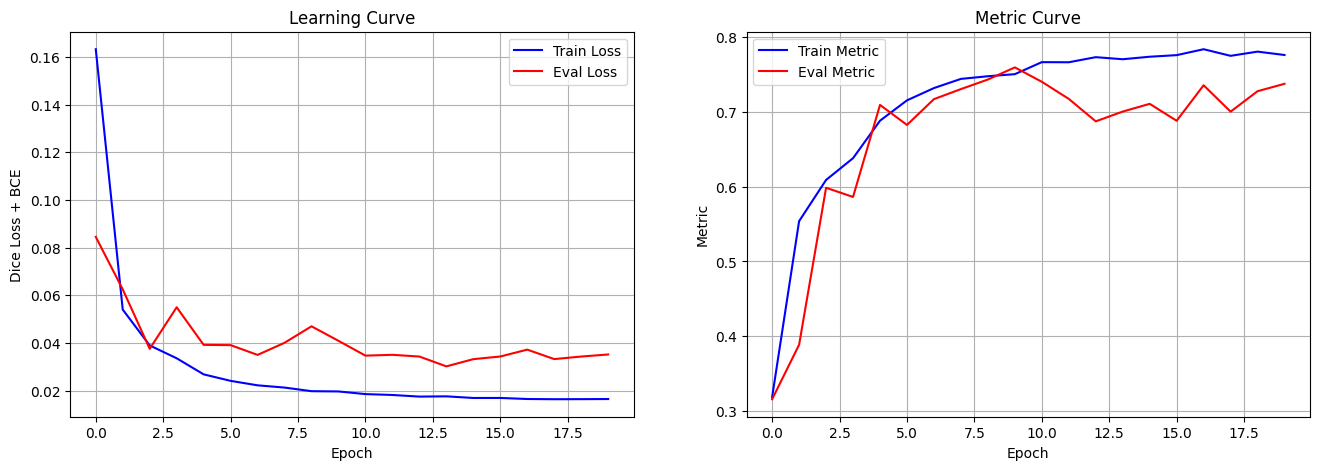

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axs[0].plot(train_loss_hist, c='b', label="Train Loss")
axs[0].plot(eval_loss_hist, c='r', label="Eval Loss")
axs[1].plot(train_metric_hist, c='b', label="Train Metric")
axs[1].plot(eval_metric_hist, c='r', label="Eval Metric")

axs[0].set_title("Learning Curve")
axs[0].set_ylabel("Dice Loss + BCE")
axs[1].set_title("Metric Curve")
axs[1].set_ylabel("Metric")

for ax in axs:
    ax.set_xlabel("Epoch")
    ax.grid()
    ax.legend()

# Test phase

In [61]:
final_model_loaded = torch.load(path.join(getcwd(), final_model_name), weights_only=False)

In [62]:
with torch.inference_mode():
    final_model_loaded.to(device)
    test_loss, test_metric = eval_one_epoch(test_loader, final_model_loaded, combined_loss_fn, metric_fn, avg_fn, device)

torch.cuda.empty_cache()

Eval ==> loss: 0.02524	metric: 0.8004



# Segmentation phase

In [63]:
test_iter = iter(test_loader)

In [64]:
with torch.inference_mode():
    final_model_loaded.to("cpu")
    test_img, test_msk = next(test_iter)

    yp = final_model_loaded(test_img)
    yp = torch.sigmoid(yp)

torch.cuda.empty_cache()

In [65]:
fig, axs = plt.subplots(nrows=test_img.shape[0]//2, ncols=4, figsize=(16, 74))
axs = axs.flatten()
axs_len = len(axs)

axs[0].set_title("Main Scan")
axs[1].set_title("Main Scan + Main Mask")
axs[2].set_title("Main Scan + Generated Mask")
axs[3].set_title("Generated Mask")

for j, i in zip(range(axs_len), range(0, axs_len, 4)):
  axs[i].imshow(test_img[j, ...].permute(1, 2, 0), cmap="gray")

  axs[i+1].imshow(test_img[j, ...].permute(1, 2, 0), cmap="gray")
  axs[i+1].imshow(test_msk[j, ...].permute(1, 2, 0), cmap="gray", alpha=0.7)

  axs[i+2].imshow(test_img[j, ...].permute(1, 2, 0), cmap="gray")
  axs[i+2].imshow(yp[j, ...].permute(1, 2, 0), cmap="gray", alpha=0.7)

  axs[i+3].imshow(yp[j, ...].permute(1, 2, 0), cmap="gray")

for ax in axs:
  ax.axis("off")

Output hidden; open in https://colab.research.google.com to view.